# Capital Bikeshare Data Management and Analysis

`
By   : Xin Gu, Shuang Zhou
`

##  Introduction

In this project, we chose the data sets from Capital Bikeshare. The data sets recorded the Capital Bikeshare trip data with trip information of date, start and end station, bike number and member type from 2010 to Oct. 2019. Historical data is valuable for business owner to draw insights, identify issues and forecast future trends. For Capital Bikeshare, with the usage and growth of their system, it would be wise to have a data management plan to fit the needs of big data and gradually build their assets as in big data . 

In the report, we recorded detailed methodology about data management pipeline implementation, took a closer look at the data by exploratory data analysis and built a regression model to predict total number of bikes needed for each hour of each day. We also proposed a way to train a better model for more accurate prediction.

##  Background

As the 2016 Capital Bikeshare Member Survey Report stated: Capital Bikeshare make reduced the cost of travel and eased the hassle car ownership and driving. More people chose to use Capital Bikeshare instead of other transportation methods for a faster and easier access to their destinations. Many Capital Bikeshare users gave high rate about most bikeshare features and show that they will use it more if bikeshare service was expanded and other service enhancements were made. 

When studying how to improve and expand bikeshare services, we are interested to answer following questions, such as how do the riders use the bikes, which stations are most popular, how to plan the quantity of bikes to meet the need for peak time riders? Upon collecting and store this kind of history data will help us make a closer look about bikeshare design, how to map the stations to mostly benefit riders, how to distribute bikes and how to promote the use of bikeshare.

Among the forementioned quesitons, this report focused on building a predictive model to predict total amount of bike share service being used in DC in each hour of the day. Intuitively, we would imaging that during evening less people utilize bike share service. A prediction model will help us to get more precised estimates then just eye-balling the historical data. The predictive power of machine learning has been broadly applied in various industries, such as manufacturing, financial services, healthcare. Banks has developed AI tools to predict the probability of loan default. AI-based demand prediction models has been deployed in car rental industry to predict service utilization.   

## 	Data Mangement and Storage

### Create VM and MongoDB Collection
First, we created a new virtual machine on Jetsream with the image of **“I535-MGMT-DATA-FA19”**. The size of the VM is m1.small with CPU: 2, Mem: 4 GB, Disk: 20 GB. For this project, we also created a 64GB volumn to attach to the VM. 

Since the MongoDB was installed and projectA database was created, so we login projectA database with login credentials:

`--> mongo -u user535 -p pass535 --authenticationDatabase projectA`

Then, we created a collection named **"bike"**. 

`> use projectA;`

`> db.createCollection("bike")`

### Extract/Data Ingestion

In this step we download the data from the data source - the Capital Bikeshare website at https://www.capitalbikeshare.com/system-data. Data was downloaded to **landDir** directory in Zip format. To download and extract each CSV file, we modified **project_utilities.py** based on the same code from projectA, Wrote a **flielists.txt** to record all the file names of zip files. (since 2018 and 2019 have seperate zip files per month, so we download those data with two more python download command)

`--> python project_utilities.py download 2010 2017`

* The screen shots shown below are about where we changed the python code to do the downloading, how it executed on the terminal.

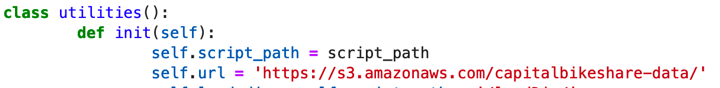

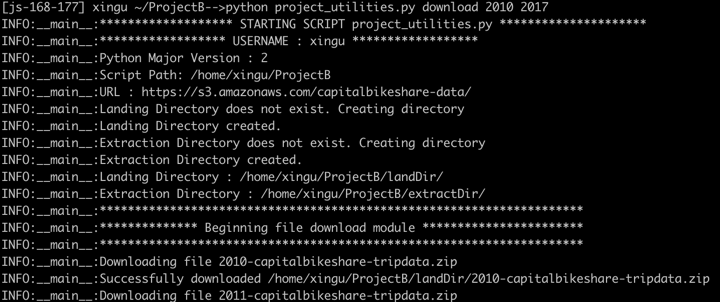

* Check the file list under landDir directory, all files are downloaded.

`~/ProjectB/landDir-->ls`

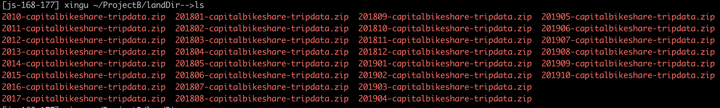

* Extract CSV files. we modified the python code shown below. And the execution results proved the success of extracting all CSV files under the directory extractDir. 

`--> python project_utilities.py extract`

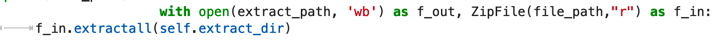

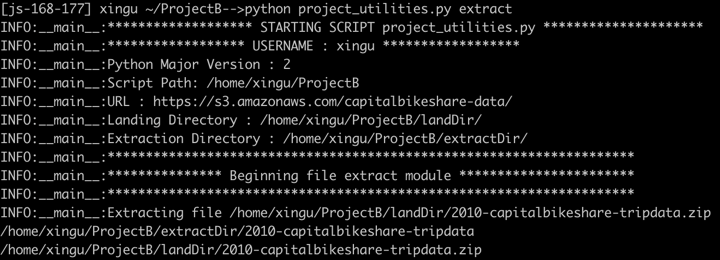

`~/ProjectB/extractDir-->ls`

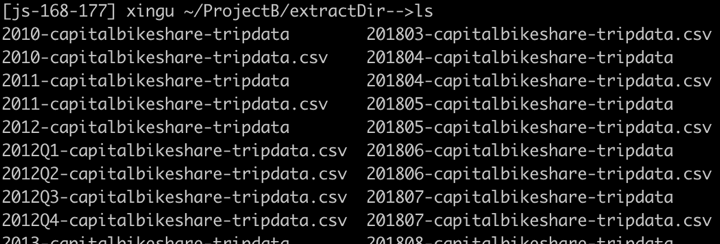

### Data Preprocessing
All CSV files need to be transformed into Json files in order to load into MangoDB. We used python script to transform all the 16 CSV files and got 120 Json files.

`--> python project_utilities.py transform 1000`

### Data Storage

Load all the transformed json files into MangoDB:

`--> python project_utilities.py load localhost 27017 projectA bike user535 pass535 `

To check the number of records in collection **bike**:

`>db.bike.find().count()`

There are 24956665 entries in the database.

To show records in collection **bike**:

`db.bike.find().pretty()`

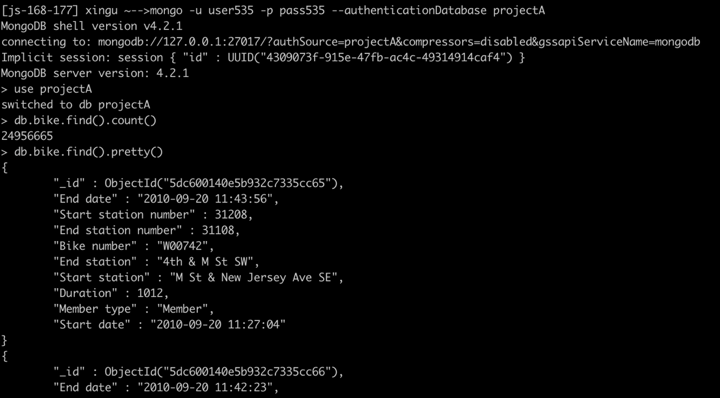

### Data Analysis with Hadoop
For the data analysis, Hadoop was installed by using **Hadoop_install.sh**. And wrote **mapper.py** and **reducer.py** to count how many times the bike trip started from the same station. 

* Hadoop installation:

    * copy the scripts spark_install.sh and hadoop_install.sh to the VM. Run commands as follows to update the permissions for hadoop_install.sh:

    `--> chmod 770 hadoop_install.sh`

    * Install Hadoop:

    `--> sudo ./hadoop_install.sh xingu`
    

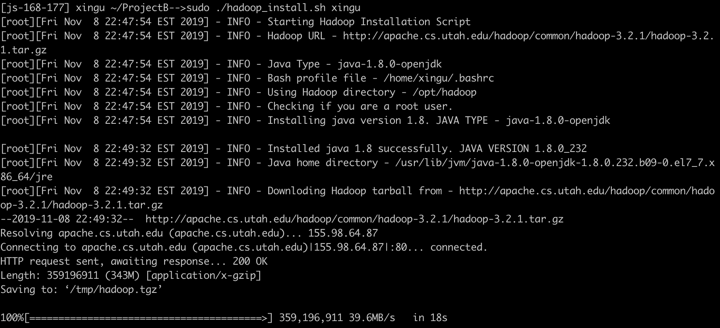

* Copy csv files to Hadoop HDFS:
    * Create Hadoop file system directory **assignment**
    
    `--> hdfs dfs -mkdir /assignment`
    
    * Move **filelist.txt** and all the csv files into Hadoop file system directory **assignment**
    
    `--> hdfs dfs -put /home/xingu/ProjectB/extractDir/*.csv /assignment`
    
    * Check the file list and there were 19 csv files
    
    `--> hdfs dfs -ls /assignment`

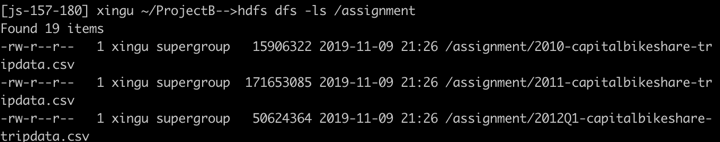

* Run map-reduce to count **Start station**

    We did map-reduce on Hadoop distributed file system(HDFS).
    
    In **mapper**, the script took in **filelist.txt**, read each line and get the name of a csv file, read in the csv file stored under the same directory, then, mapped **["Start station number"]+'\t'+str(1)** pairs for every entry. The **mapper** worked through every csv file in the **filelist.txt**. Based on the mapper results, **reducer** counted the total number of each **“Start station number”**.   

    `   --> hadoop jar /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.2.1.jar -mapper /home/xingu/ProjectB/mapper.py -reducer /home/xingu/ProjectB/reducer.py -input /assignment/fileslist.txt -output /assignment-output10`
    



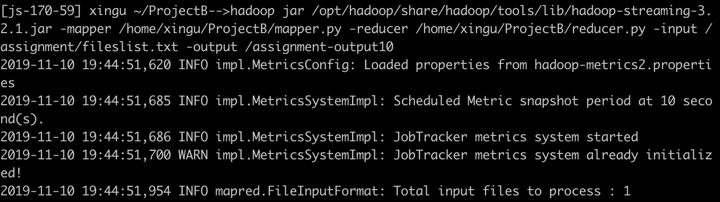

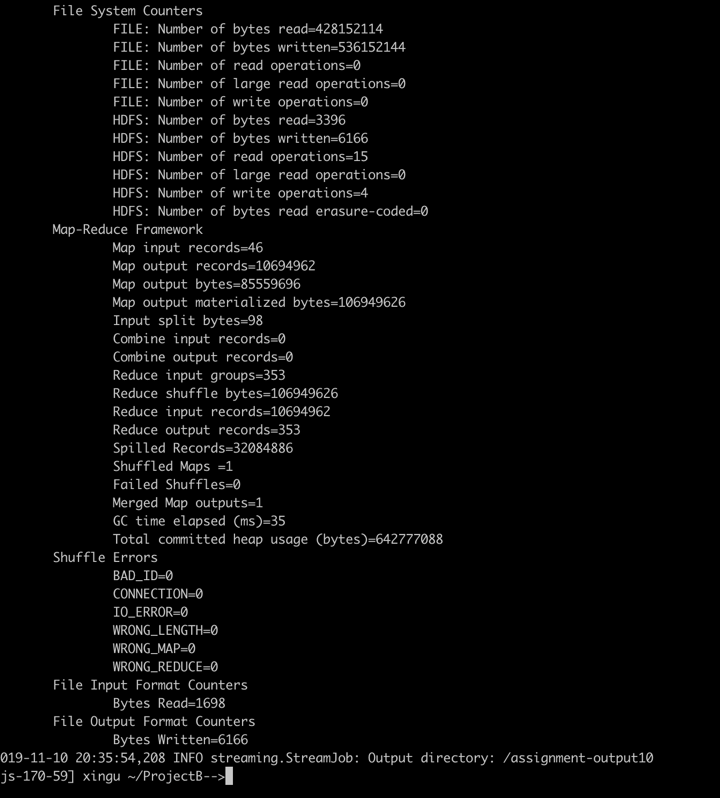

* Get the map-reduce results:
     * copy and save **part-000** from hdfs to local directory

`-->hdfs dfs -get /assignment-output10`

`-->cd assignment-output10`
   
`-->cp part-0000 /home/xingu/ProjectB/results.csv`


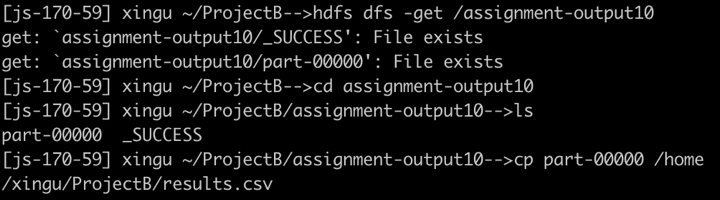

* The map-reduce results:

    `-->vi part-0000`

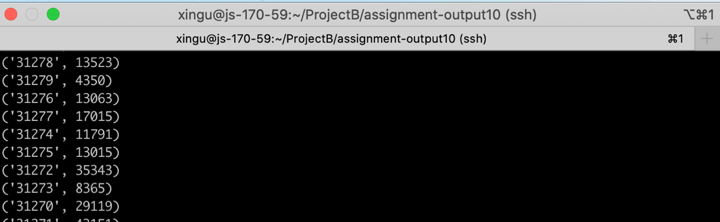

### Trouble shooting

When running map-reduce on Hadoop hdfs, we ran into error because of low storage capacity. So we built an 64GB **volumn** and attached to VM, removed all the downloaded zip files and moved all the json files and CSV files into **volumn** to make more storage space available on VM (could be simply removed, since we already loaded our data into MangoDB.) 

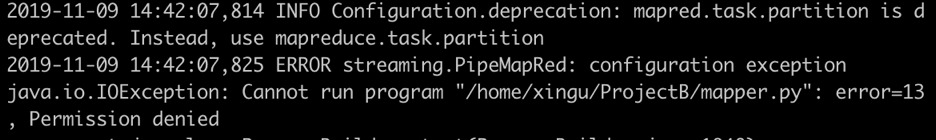

After cleared up more storage space, we run following code to trun **Safe Mode** OFF:

`-->hdfs dfsadmin -safemode leave`

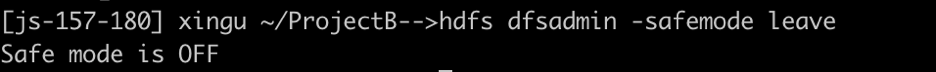

Then, map-reduce run as expected.

## Data Analysis and machine learning with Python


### Prepare the notebook

In [27]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import os
import warnings
warnings.filterwarnings('ignore')
from pprint import pprint

#classifiaction.
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

#regression
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

#model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#evaluation metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score  # for classification


### Load the Data 

In [4]:
pwd

'/root/shared/Documents/INFO_IS535_Big_and_Complex_Data/Project_B/BigDataProjectB'

In [5]:
DATA_DIR = '/root/shared/Documents/INFO_IS535_Big_and_Complex_Data/Project_B/BigDataProjectB'

In [27]:
def load_data(in_path, name):
    df = pd.read_csv(in_path)
    print(f"{name}: shape is {df.shape}")    
    return df

In [75]:
datasets={}
ds_names = ("201901", "201902", "201903","201904","201905","201906","201907","201908","201909","201910")

for ds_name in ds_names:
    datasets[ds_name] = load_data(os.path.join(DATA_DIR, f'{ds_name}-capitalbikeshare-tripdata.csv'), ds_name)

201901: shape is (150780, 9)
201902: shape is (158130, 9)
201903: shape is (253811, 9)
201904: shape is (347992, 9)
201905: shape is (337704, 9)
201906: shape is (350144, 9)
201907: shape is (356645, 9)
201908: shape is (360044, 9)
201909: shape is (360225, 9)
201910: shape is (337552, 9)


In [77]:
# combine datasets into one table
df = pd.concat(datasets)
df.reset_index(drop=True,inplace=True)
df['Index']=df.index
print("df.shape: ", df.shape)
df.head()

df.shape:  (3013027, 10)


,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type,Index
0,230,2019-01-01 00:04:48,2019-01-01 00:08:39,31203,14th & Rhode Island Ave NW,31200,Massachusetts Ave & Dupont Circle NW,E00141,Member,0
1,1549,2019-01-01 00:06:37,2019-01-01 00:32:27,31321,15th St & Constitution Ave NW,31114,18th St & Wyoming Ave NW,W24067,Casual,1
2,177,2019-01-01 00:08:46,2019-01-01 00:11:44,31104,Adams Mill & Columbia Rd NW,31323,Woodley Park Metro / Calvert St & Connecticut ...,W22654,Casual,2
3,228,2019-01-01 00:08:47,2019-01-01 00:12:35,31281,8th & O St NW,31280,11th & S St NW,W22336,Member,3
4,1300,2019-01-01 00:12:29,2019-01-01 00:34:10,31014,Lynn & 19th St North,31923,Columbia Pike & S Taylor St,70004,Member,4


### Prediction Modeling

#### Data Fields

* Duration - Time of the trip in minutes
* Start date - hourly date + timestamp 
* End date - hourly date + timestamp
* Start station number - ID number of start station
* Start station - Address of the station
* End station number - ID number of end station
* Bike number - ID number of bike
* Member type - 'Member', 'Casual'

#### Missing Data

In [20]:
for data_name in ds_names:
    
    for name in datasets[data_name].columns:
        missing_proportion=datasets[data_name][str(name)].isna().sum()/datasets[data_name].shape[0]*100
        if missing_proportion > 0:
            print ("\033[1mFeatures with missing values in \033[94m"+str(data_name)+" dataset \033[0m \n")
            print ("\033[1mFeatures"+ (29-len("Features"))*" "+"Missing proportion"'\033[0m')
            print (" "+str(name)+":"+ (29-len(str(name)))*" "   +"\033[91m%"+str(np.round(missing_proportion,3)),'\033[0m')


Features with missing values in 201906 dataset  

Features                     Missing proportion
 Bike number:                  %0.004 


By counting the missing values of each feature in every datasets, we found that only dataset **201906** has missing value about 0.004% in **Bike number**. 

#### Feature engineering and EDA

In [1]:
files=['201901','201902','201903','201904','201905','201906','201907','201908','201909', '201910']

def merge_data(trials_name):
    merged=pd.DataFrame()
    for name in trials_name:
        a1=pd.read_csv(name+'-capitalbikeshare-tripdata.csv', parse_dates=['Start date','End date'])
        a1=a1.groupby(pd.Grouper(key='Start date',freq='H')).agg({'Bike number':'count'}).reset_index()        
        print(name)
        print(a1.info())
        merged=merged.append(a1, ignore_index=True, sort=False)
        
    dr = pd.date_range(start='2019-01-01', end='2019-10-31')
    cal = calendar()
    holidays = cal.holidays(start=dr.min(), end=dr.max())
    # false is not a holiday, true is a holiday
    merged['Holiday'] = merged['Start date'].isin(holidays)
    merged['Holiday'] = (merged['Holiday']*1).astype('category')
    # Monday to Sunday is 0 to 6
    merged['weekday'] =merged['Start date'].dt.dayofweek.astype('category')
    #Winter month(1) is 12, 1,2, Spring(2) is 3,4,5,, summer(3) is 6,7,8, fall(4) is 9,10,11
    merged['Season']=((merged['Start date'].dt.month%12+3)//3).astype('category')
    return merged

In [3]:
dataset=merge_data(files)

201901
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 2 columns):
Start date     744 non-null datetime64[ns]
Bike number    744 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.7 KB
None
201902
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 2 columns):
Start date     672 non-null datetime64[ns]
Bike number    672 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 10.6 KB
None
201903
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 2 columns):
Start date     744 non-null datetime64[ns]
Bike number    744 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.7 KB
None
201904
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 2 columns):
Start date     720 non-null datetime64[ns]
Bike number    720 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.3 KB
N

In [4]:
dataset.head()

,Start date,Bike number,Holiday,weekday,Season
0,2019-01-01 00:00:00,60,1,1,1
1,2019-01-01 01:00:00,107,0,1,1
2,2019-01-01 02:00:00,102,0,1,1
3,2019-01-01 03:00:00,25,0,1,1
4,2019-01-01 04:00:00,14,0,1,1


QQ plot shows that the distribution of "Bike number" is close to normal distribution.

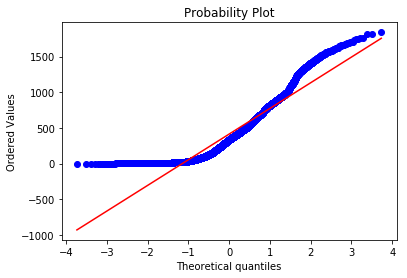

In [5]:
#Q-Q Plot
from scipy import stats
plt = stats.probplot(dataset['Bike number'], plot=sn.mpl.pyplot)

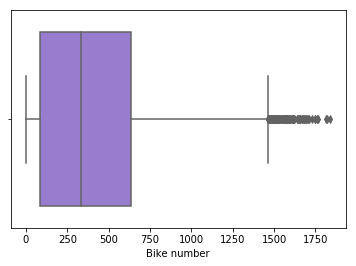

In [6]:
#Boxplot for count
sn.boxplot(x = 'Bike number', data = dataset, color = 'mediumpurple')

In [7]:
#Calculating the number of outliers
Q1 = dataset['Bike number'].quantile(0.25)
Q3 = dataset['Bike number'].quantile(0.75)
IQR = Q3 - Q1
outliers = dataset[(dataset['Bike number'] < (Q1 - 1.5 * IQR)) | (dataset['Bike number'] > (Q3 + 1.5 * IQR))]
print((len(outliers)/len(dataset))*100)


1.6036184210526316


In [8]:
#Data without the outliers in count
dataset = dataset[~dataset.isin(outliers)]
dataset = dataset[dataset['Start date'].notnull()]

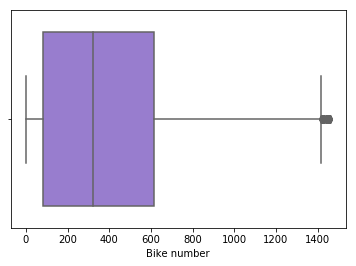

In [9]:
#Boxplot for count
sn.boxplot(x = 'Bike number', data = dataset, color = 'mediumpurple')

In [10]:
dataset['Hour']=dataset['Start date'].dt.hour #hour is from 0 to 23

dataset['Month']=dataset['Start date'].dt.month

dataset.drop('Start date',axis=1,inplace=True)

In [11]:
dataset.head(5)

,Bike number,Holiday,weekday,Season,Hour,Month
0,60.0,1,1,1,0,1
1,107.0,0,1,1,1,1
2,102.0,0,1,1,2,1
3,25.0,0,1,1,3,1
4,14.0,0,1,1,4,1


In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7179 entries, 0 to 7295
Data columns (total 6 columns):
Bike number    7179 non-null float64
Holiday        7179 non-null category
weekday        7179 non-null category
Season         7179 non-null category
Hour           7179 non-null int64
Month          7179 non-null int64
dtypes: category(3), float64(1), int64(2)
memory usage: 246.0 KB


In [13]:
dataset.to_pickle("dataset.pkl")

The dataset are missing one month of data in winter and one month of data in fall season. From the following graph, we can still see that warmer seasons have higher bike usages. It is highly likely that summer and fall are the two peak seasons. 

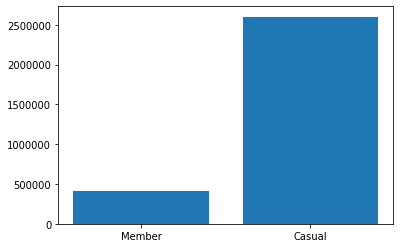

In [99]:
# Bar plot of Count of Member and Casual users
plt.bar(np.arange(len(df["Member type"].unique())), df.groupby("Member type")["Index"].count())
_=plt.xticks(np.arange(len(df["Member type"].unique())), ['Member', 'Casual'])

[Text(0, 0.5, 'average count')]

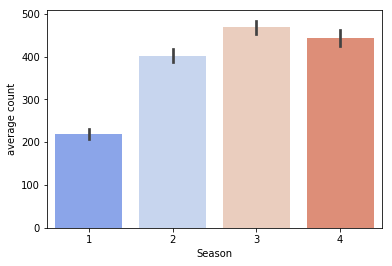

In [14]:
ax=sn.barplot(x = 'Season', y = 'Bike number', data = dataset, estimator = np.average, palette='coolwarm')
ax.set(ylabel='average count')

Saturdays has the least bike usage within the week. 

[Text(0, 0.5, 'average count')]

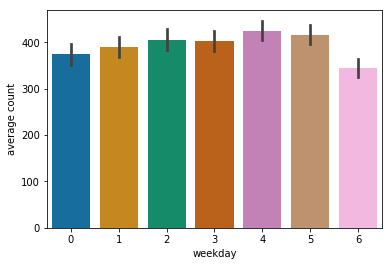

In [15]:
ax=sn.barplot(x = 'weekday', y = 'Bike number', data = dataset, estimator = np.average, palette='colorblind')
ax.set(ylabel='average count')

It is not surprising to see that rush hours have the highest bike usages within a day.

[Text(0, 0.5, 'average count')]

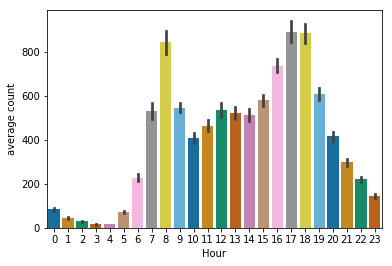

In [16]:
ax=sn.barplot(x = 'Hour', y = 'Bike number', data = dataset, estimator = np.average, palette='colorblind')
ax.set(ylabel='average count')

When the weather becomes amicable, there are a rather fixed number of people who will go for a bike ride. The bike counts are rather similiar from April to September. 

[Text(0, 0.5, 'average count')]

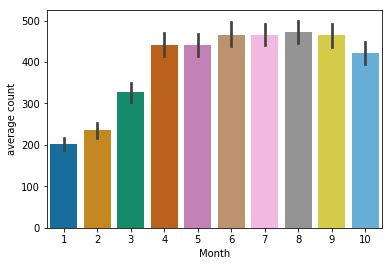

In [17]:
ax=sn.barplot(x = 'Month', y = 'Bike number', data = dataset, estimator = np.average, palette='colorblind')
ax.set(ylabel='average count')

Varaible Hour has stronger correlation then variable Month in terms of bike count. It is obvious that bike count fluctuates more when plotting against varialbe Hour then variable Month. 

#### Correlation Analysis

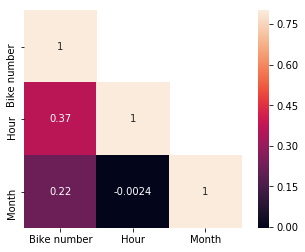

In [60]:
# correlation analysis

corrMatt = dataset.corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
#fig=plt.gcf()
#fig.set_size_inches(20,10)
ax=sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

In [ ]:
cor_mat= df[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

#### Model Tuning

After comparing several regressor, the RandomeForestRegressor has the least prediction error

In [18]:
x_train,x_test,y_train,y_test=train_test_split(dataset.drop('Bike number',axis=1),dataset['Bike number'],test_size=0.25,random_state=42)

In [19]:
models=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor(), LinearRegression()]
model_names=['RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor', 'LinearRegression']
mse=[]
acc=[]
for i in range (len(models)):
    clf=models[i]
    clf.fit(x_train,y_train)
    test_pred=clf.predict(x_test)
    mse.append(mean_squared_error(test_pred,y_test))
    #acc.append(accuracy_score(test_pred, y_test))
rmsle_frame=pd.DataFrame({'Modelling Algo':model_names,'mse':mse})
print(rmsle_frame)

          Modelling Algo            mse
0  RandomForestRegressor   21560.041181
1      AdaBoostRegressor   45506.186855
2       BaggingRegressor   21656.750798
3                    SVR   90777.091738
4    KNeighborsRegressor   23944.748457
5       LinearRegression  100949.238251


Let's take a look at the parameter currently used by Random Forest Regressor. 

In [28]:
clf=RandomForestRegressor()
print('Parameters in RandomForestRegressor:\n')
pprint(clf.get_params())

Parameters in RandomForestRegressor:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In order to fine tune the model, its existing hyper parameter needs tunning with more details. 
n_estimators: number of trees in the foreset
max_features: max number of features considered for splitting a node
min_samples_split: min number of data points placed in a node before the node is split
min_samples_leaf: min number of data points allowed in a leaf node
bootstrap: method for sampling data points (with or without replacement)

In [34]:

n_estimators = [100,200,400,600,900]
max_features = ['auto', 'sqrt']
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
# Create the random grid
params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs_rfr = GridSearchCV(clf, params, cv = 5, scoring = 'neg_mean_squared_error',verbose=2, n_jobs = -1)
# Fit the random search model
gs_rfr.fit(x_train, y_train)
test_pred = gs_rfr.predict(x_test)
print (gs_rfr.best_params_)
print ("mse: ", mean_squared_error(test_pred, y_test))

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  8.1min finished


{'bootstrap': True, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
mse:  17630.44901933052


The best random forest regressor model gave out 3930 reduction in MSE which improves the accuracy of the prediciton. 

## Discussion

### Pipeline for data management:

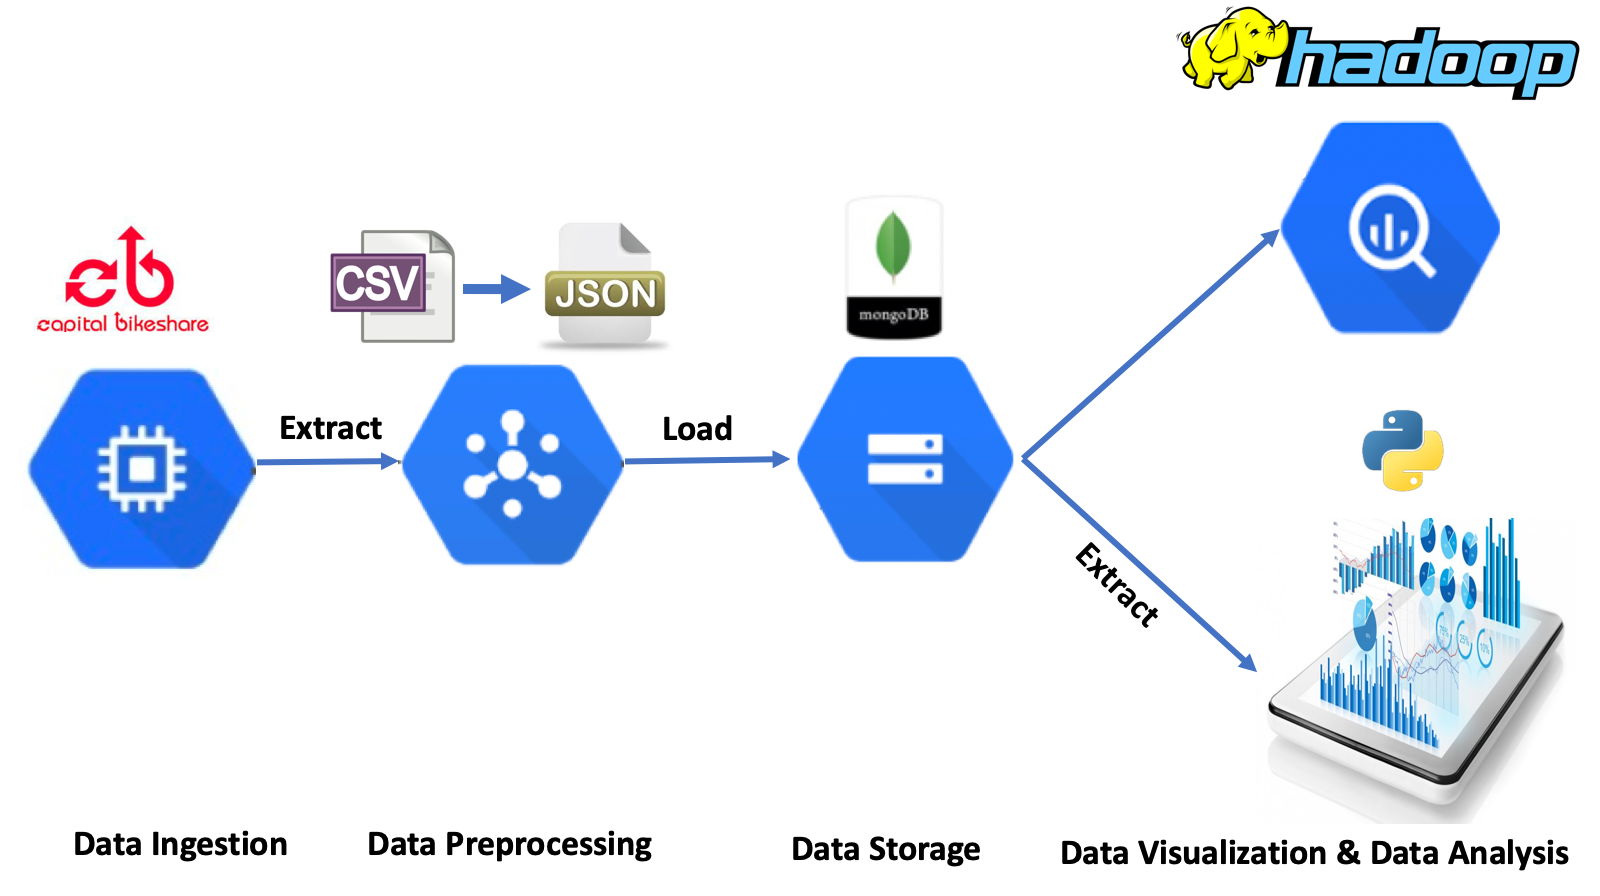

Data pipeline gives users a framework about data management, it tracks how data was handled or generated and help ensure data integrity. The pipeline for the project has 5 steps, including data ingestion, data processing, data storage, data visualization and data analysis. 

#### Data Ingestion

In data ingestion, we download zip files containing the historical capital bikeshare data from 2010 to 2019. Individule file was stored in CSV format. Those CSV files in this project were compressed into zip files to reduce strorage space. CVS is a good long-term preservation option which is a basic and commonly used plain text format with commas as separators. It stores data in tabular manner, every record is in a line. Since it is plain text, they can be easily transformed into Json format.  In addition, CSV file format is supported by Hadoop platform, and widely used in Machine Learning algorithms which will benifit our implementation of analysis in Hadoop and Python.

#### Data Processing and Data Storage

In Capital bikeshare data file, every trip made a row containing informationa about **"Start date"**, **"Start station number"**, **"End station number"** and etc. To find a database suitable for store Capital bikeshare data, we need a database which is scalable and powerful to handle Big Data. NoSQL databases (such as CouchBase and MangoDB) are better choice over SQL-based database. First, Capital bikeshare will update database by rows and read/write frequently, the bikeshare trip data is ever growing. NoSQL is scalable, it allows scale up without any change of the overall data structure. Second, noSQL data collection can take any types of record such as images or other complex technical data, that will be a good feature for future trip description, such as pictures about stations. Third, it offers high availability which guarantees continuous monitoring about bike use and station status updates. Last but not least, bikeshare data is always added but not updated, in that way noSQL databases offer higher performance than relational databases. Due to CAP theorem, in this big data system we can’t have data consistency and system availability at the same time. However, for this kind of data, users usually don’t care much about its consistency and want to be prepared for future scaling up. Based on above consideration, we chose MangoDB as data storage mothod for this project.

#### Data Analysis in Hadoop

Hadoop is an opensource platform for storing and analyzing big data. Users can store large amount of data sets in separated clusters of servers, which made doing applications and analysis fast and efficient in each cluster. As for this project, we have 19 CSV files which is not very big. But still, we don’t need to take storage space in our local computer and don’t need to transfer big amount of data over network which is time consuming and has risk of failures. 

Distributed file system (DFS) and MapReduce are two main components of Hadoop. We moved data in DFS and run mapreduce to count the number of bikes which were taken from each start station over last 10 years. It took about 50 minutes to go over all the data. By reading the mapreduce framework, we can see that mapper output 10694962 records and reducer sorted all the output records and returned counts of 353 different stations. Since Hadoop use moduels to handle different function of Big Data system, such as data storage module, compute engine module and data management system module and etc. We can easily integrate other modules on Hadoop platform, such as Apache Spark, it is designed as an alternation of MapReduce for the ease of use. 

#### Data Visualization

There are softwares and programming languages can be used to do exploratory data analysis and data visualization, including applications provided by Hadoop ecosystem. Here, we chose python as tool and did visualizations. There are more casual riders than members. Riders are more willing to ride a bike with warmer weather. The number of riders is consistent during the month of April to September, and drops during winter. Plus, more riders during the rush hour and weekdays, indicating commuter usage.


### Data Analysis and machine learning

A regression model was trained in Python programming language to predict total number of bikes needed for each hour of each day. Only 2019 data was used to train the model. The procedure of model set up and training is depicted in following graph. EDA could be preformed once again after feature engineering. 

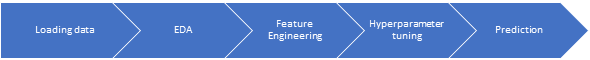


Several factors directly affect how people decide to utilize bike sharing or not. Weather related information, such as outdoor temperature, wind speed, sunny or rainy is one of the strongest factors. The regression model did not include such features, which could make the model not as accurate as we’d hope. Vicky Wang in her Ted talk emphasized the importance of “thick data” in terms of accuracy of predictive models using big data. Thick data was referred to information that related to cultural, social and other information that has not been collected. This concept can also expand to include any confounding factors that has not been included in predictive model. In our case, weather is one of the biggest confounding factors. The service charge, the station locations, and the condition of the bikes are examples of other confounding factors, that was not included in the prediction model. 

This is a rather small dataset in terms of amount of data and features, and only has a few outliers need to be cleaned from the dataset. We used it to mainly showcase the pipeline building a prediction model using python Scikit Learning package. Most of the real-life application of machine learning would have huge amount of data, a lot of features to be sorted out, and not surprisingly, heavy amount of data cleaning work load. Data cleaning can easily make up 80-90% of effort when building a prediction model.  


## Conclusion

This report is about data management pipeline implementation with understanding and learning from this course. Data pipeline is a framework about data life cycle, it tracks how data was handled or generated and helps ensure data integrity. To better understand data and draw insights from historical data, building data management capacity will create sustainable competitive advantages for businesses. Last but not least, we should always keep in mind that we are using data as a tool to serve human, understanding the human lives, underlying emotions or culture trends are key factors when we are making decisions.  


## References

[1] https://www.capitalbikeshare.com/system-data

[2] https://readwrite.com/2013/05/23/hadoop-what-it-is-and-how-it-works/

[3] Lorenco et al. (2015). Choosing the right NoSQL database for the job: A quality attribute evaluationPreview the document. Journal of Big Data, 2. doi: 10.1186/s40537-015-0025-0

[4] https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-hdfs/HDFSCommands.html

## Author Contribution Statements

Xin contributed to data management pipeline in designing, implementation and writting. Shuang contribued to data analysis and machine learning in designing, implementation and writting. Both Author contributed to Background, Discussion and Conclusion.